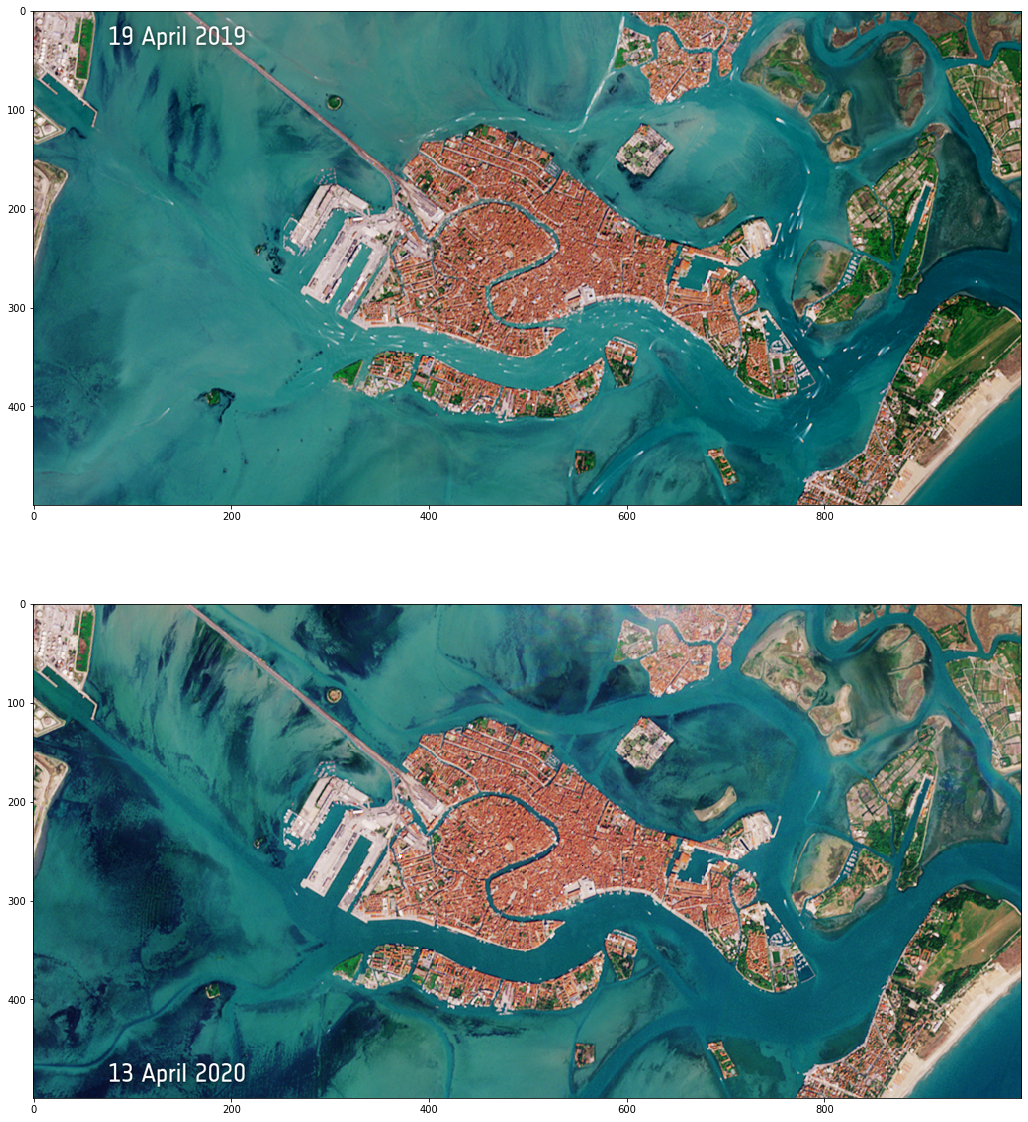

In [1]:
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgba2rgb

fig, ax = plt.subplots(2, 1, figsize=(20, 20))
im = imread('Venice_2019.png')
im2 = imread('Venice_2020.png')
im = rgba2rgb(im)
im2 = rgba2rgb(im2)
ax[0].imshow(im)
ax[1].imshow(im2)

Partie TIFO
======

Cette fonction retourne une image avec les eaux ségmentées. Pour cela on utilise un masque qui va passer au noir les couleurs différentes de la couleur de l'eau. Ensuite on binarise l'image en mettant à 1 toutes les pixels non compris dans le masque. A l'etape suivante, on effectue une fermeture sur la zone proche du canal principale de manière à elargir ce canal. Enfin, on rempli les trous et on fait une fermeture pour effacer les points noir sur l'arrière plan blanc de l'image.

In [2]:
path = 'Venice_2019.png'

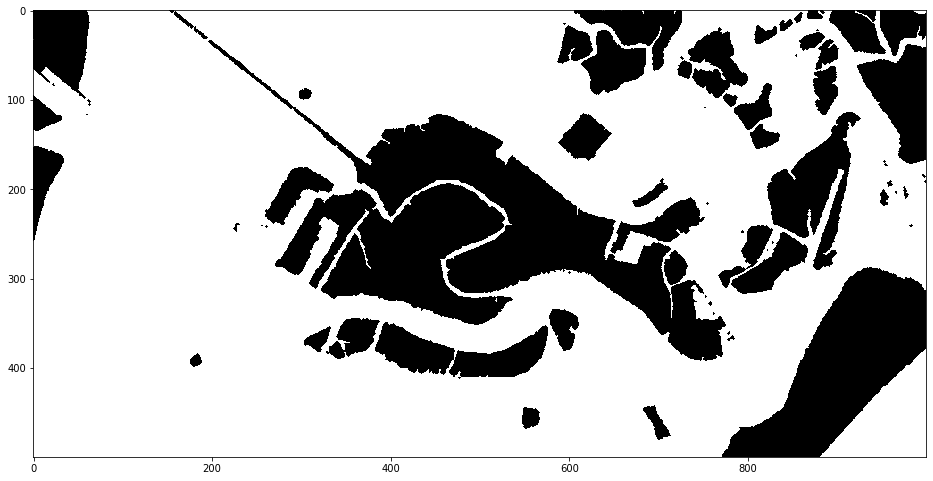

In [3]:
from skimage.morphology import disk, remove_small_objects, binary_dilation, disk, binary_opening, binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from skimage.io import imread
from skimage.color import rgba2rgb

def get_segmented_water(path):
    struct_closing = disk(3)
    struct_closing_second = disk(1)
    struct_opening = disk(1)

    image = imread(path)
    image = rgba2rgb(image)
    mask = ((image[..., 2] < image[..., 0]) | (image[..., 2] / image[..., 1] < 0.7) 
    | ((image[..., 1] / (image[..., 0] + image[..., 2]) > 0.7) & (image[..., 2] < 0.15))
    | ((image[..., 0] / (image[..., 1] + image[..., 2]) > 0.3) & (image[..., 2] < 0.3)))
    image[mask, :] = 0
    mask = np.any(image > 0, axis=2)
    image[mask] = 1
    binary_image = image[..., 0].astype(np.bool)
    binary_image[190:320, 320:550] = binary_closing(binary_image[190:320, 320:550], struct_closing).astype(np.bool)
    binary_image[150:250, 850:900] = binary_opening(binary_image[150:250, 850:900], struct_opening).astype(np.bool)
    inverted = np.invert(binary_image)
    filled = binary_fill_holes(inverted).astype(np.bool)
    inverted = np.invert(filled)
    water_segmented = binary_closing(inverted, struct_closing_second).astype(np.bool)
    return water_segmented

seg = get_segmented_water(path)
plt.figure(figsize=(16, 9))
plt.imshow(seg, cmap='gray')

Cette fonction permet d'obtenir la date ségmentée sur les 6 images. Pour se faire, on commence par masquer l'image de manière à ne garder que les pixels de plus forte intensité (la date est écrite en blanc). Ensuite, et puisque les dates sont écrites dans des coins de l'image, on passe au noir toute la zone centrale de l'image. Après cela on se debarasse des pixels situés au bord de l'image de manière à ce qu'il n'y ait pas de pixel trop proche de la date.

Ensuite vient la partie la plus importante: on dilate l'image de manière à ce que la date ne forme qu'un seul bloc. On se débarasse ensuite des concurrents potentiels en enlevant les blocs de taille inférieur à la taille de la date. Enfin, on élimine les gros blocs restant en filtrant en fonction de l'exentricité de la région ainsi que de l'extent (rapport nombre de pixels dans la region sur nombre de pixels dans la bounding box).

On se retrouve finalement avec un seul et unique masque blanc sur fond noir au niveau de la date. On se sert de ce masque sur l'image originelle pour ne récupérer que la date.

Pour finir, on enlève les petits elements se trouvant autour de la date, on veille à ce que ces élements aient une taille inférieur au point du 'i' du mot 'april'. Finalement, on effectue une dilatation avec un element structurant de taille minimale (taille 1) pour avoir des lettres plus 'remplies'.

La méthode utilisée est la même pour les images de tulipes comme pour les images de Venise, seul les paramètres sont changés.

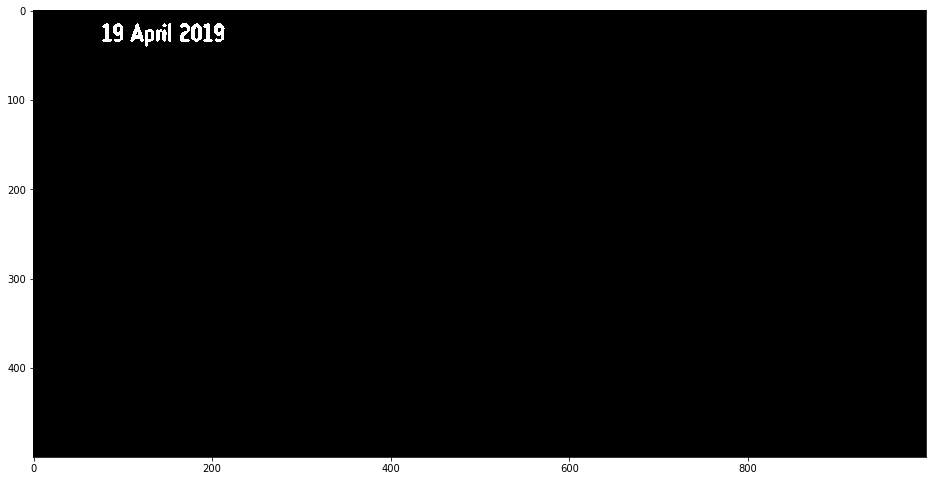

In [4]:
from skimage.morphology import remove_small_objects, binary_dilation, disk, binary_opening, binary_closing
from skimage.segmentation import clear_border, flood, flood_fill
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import binary_fill_holes
from skimage.filters import threshold_yen, threshold_otsu

def process_image(test_number, disk_size, bit_row, thresh, bit_row_mul, small_objects_size, space_size, small_objects_size_second):
    struct = disk(disk_size)
    bit_row = test_number.shape[0] // bit_row
    bit_col = test_number.shape[1] // 3
    space = space_size
    struct_dilation = disk(1)

    mask = (test_number[..., 0] < thresh) | (test_number[..., 1] < thresh) | (test_number[..., 2] < thresh)
    test_number[mask, :] = 0
    mask = np.any(test_number > 0, axis=2)
    test_number[mask] = 1
    test_number = test_number[..., 0].astype(np.bool)
    test_number[bit_row:bit_row * bit_row_mul, :] = 0
    test_number[:, bit_col:bit_col * 2] = 0
    test_number = clear_border(test_number, space)

    test_number_dilated = binary_dilation(test_number, struct).astype(np.bool)
    test_number_dilated = binary_fill_holes(test_number_dilated).astype(np.bool)
    test_number_dilated = remove_small_objects(test_number_dilated, small_objects_size)

    l = label(test_number_dilated)
    for region in regionprops(l):
        if region.eccentricity < 0.95 or region.extent < 0.63:
            centroid = tuple([int(x) for x in region.centroid])
            l = flood_fill(l, tuple(region.coords[0, :]), 0)

    l[l > 0] = 1
    test_number[l == 0] = 0
    test_number = remove_small_objects(test_number, small_objects_size_second)
    test_number = binary_dilation(test_number, struct_dilation)
    return test_number, test_number_dilated

def get_date(path):

    test_number = imread(path)
    test_number = rgba2rgb(test_number)

    if test_number.shape[:-1] == (500, 1000):
        test_number, test_number_dilated = process_image(test_number, 7, 7, 0.65, 6, 4000, 10, 3)

    else:
        test_number, test_number_dilated = process_image(test_number, 12, 8, 0.75, 7, 18000, 15, 18)

    return test_number, test_number_dilated

date, date_mask = get_date(path)
plt.figure(figsize=(16, 9))
plt.imshow(date, cmap='gray')


Cette fonction permet de compter le nombre de bateaux. On seuille d'abord l'image avec un seuil assez élevé de manière à ne récupérer que les elements les plus clairs (les bateaux sont blancs). Après cela, on érode legerement l'image des eaux ségmentés et on se sert de cette image comme masque pour supprimer les points blancs qui ne sont pas sur l'eau. On utilise également le masque de la date obtenu precedemment pour supprimer la date de l'image. Enfin le dernier masque utilisé est celui de l'image binarisée grâce au threshold de yen. Tous les pixels à 0 dans l'image de Yen sont également passés à 0 dans notre image. Ensuite on elimine les pixels qui touchent le bord de l'image ainsi que les régions trop grosses (dont le nombre de pixels est supérieur à 150 en pratique). On élimine egalement les régions ayant un extent trop faible (inférieur à 0.4). Enfin on labelise l'image en demendant de retourner le nombre de labels/regions.

Le nombre de bateaux estimé sur l'image est de: 282


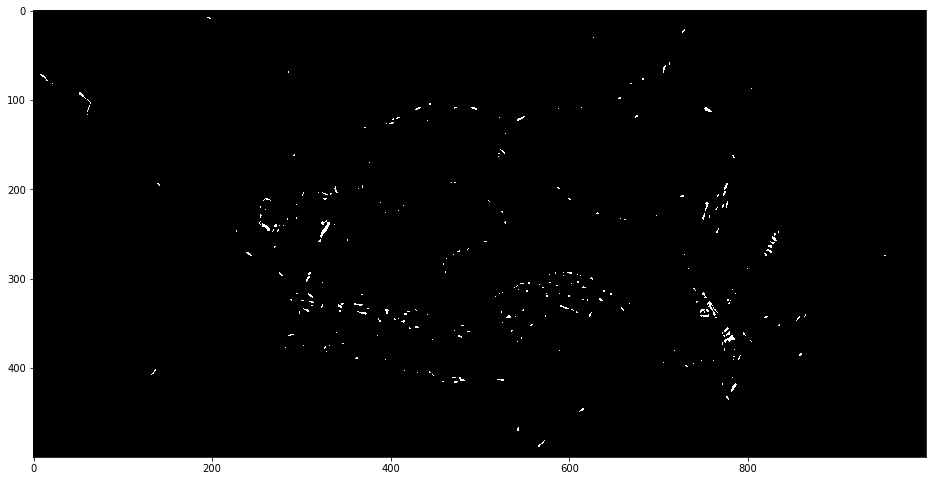

In [5]:
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, remove_small_objects, binary_dilation, disk, binary_opening, binary_closing
from skimage.segmentation import clear_border, flood, flood_fill
from skimage.measure import label, regionprops
from skimage.filters import threshold_yen, threshold_otsu
from scipy.ndimage.morphology import binary_fill_holes

def count_ships(path, seg, date_mask):
    struct = disk(2)

    seg = binary_closing(seg, struct).astype(np.bool)
    im = imread(path)
    im = rgba2rgb(im)
    grayscale = rgb2gray(im)

    thresh = threshold_yen(grayscale)
    yen = grayscale > thresh

    eroded = binary_erosion(seg, struct).astype(np.bool)

    grayscale = grayscale > 0.6

    grayscale[(eroded == 0) | (date_mask == 1) | (yen == 0)] = 0

    grayscale[date_mask == 1] = 0
    grayscale = binary_fill_holes(grayscale)
    grayscale = clear_border(grayscale)
    l = label(grayscale)
    for region in regionprops(l):
        if region.area > 100 or region.extent < 0.2:
            grayscale = flood_fill(grayscale, tuple(region.coords[0, :]), 0)

    label_image, num = label(grayscale, return_num=True)
    return num, grayscale

num, ships = count_ships(path, seg, date_mask)
print(f'Le nombre de bateaux estimé sur l\'image est de: {num}')
plt.figure(figsize=(16, 9))
plt.imshow(ships, cmap='gray')

partie PRSTIM
=======

Pour trouver les fonctions de densité à rattacher aux hypothèses H0 et H1, on peut se donner une idée en affichant l'histogramme de l'image représentant la différence entre l'image de venise en 2019 en niveau de gris, et l'image de venise en 2020 en niveau de gris. On obtiendra ainsi une image où la valeur des pixels représente l'ampleur du changement entre les deux dates.

0.12535595153325102


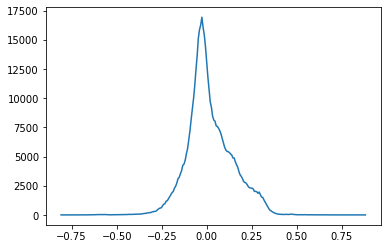

In [6]:
from skimage.exposure import histogram
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray
import numpy as np
from matplotlib import pyplot as plt

im = imread('Venice_2019.png')
im2 = imread('Venice_2020.png')
im = rgba2rgb(im)
im2 = rgba2rgb(im2)
grayscale1 = rgb2gray(im)
grayscale2 = rgb2gray(im2)
diff = grayscale1 - grayscale2
print(diff.std())
histo, hist_centers = histogram(diff)
plt.plot(hist_centers, histo)
plt.show()

On remarque que l'histogramme a la forme d'une loi normale plus ou moins centrée autour de 0. On va donc essayer de modéliser nos deux hypothèses par des lois normales. Intuitivement, il semble raisonnable de choisir pour H0, l'hypothèse qui représente l'absence de changement, une moyenne de 0. On a affiché aussi l'écart type de l'image différence qui est ici de 0.125 et qui sera considéré comme notre bruit pour les lois H1 et H0. Pour simplifier les calculs on partira sur un ecart type similaire pour H0 et H1. On constate également sur l'histogramme plusieurs 'mini pics'. Les deux plus importants se situent autour de 0.125 et autour de 0.25. On pourrait donc décider de partir sur une moyenne de 0.2 pour notre loi H1. Cependant pour être sûr de la moyenne de la loi H1, on va afficher l'histogramme de la difference des deux images mais en gardant uniquement les pixels susceptibles de representer un bateau.

Pour se faire, on va utiliser l'image de sortie de notre fonction 'count_ships' de la partie TIFO. Ces deux images, qui sont des images binaires des bateaux de venise en 2019 et venise en 2020 vont nous servir de masque à appliquer sur l'image différence en niveu de gris pour conserver uniquement les bateaux sur l'image différence. Ensuite on affiche l'histogramme de cette image.

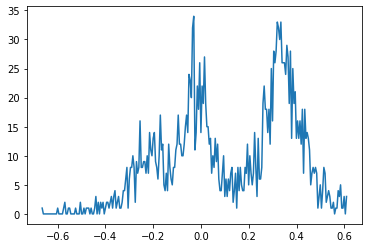

In [7]:
from skimage.exposure import histogram

water_2019 = get_segmented_water('Venice_2019.png')
date, date_mask_2019 = get_date('Venice_2019.png')
num, ships_2019 = count_ships('Venice_2019.png', water_2019, date_mask_2019)
water_2020 = get_segmented_water('Venice_2020.png')
date, date_mask_2020 = get_date('Venice_2020.png')
num, ships_2020 = count_ships('Venice_2020.png', water_2020, date_mask_2020)
histo, hist_centers = histogram(diff[(ships_2019 > 0) | (ships_2020 > 0)])
plt.plot(hist_centers, histo)
plt.show()

On voit clairement apparaître deux pics: l'un autour de zero lorsque la difference entre les deux images des bateaux ne donne pas de changement, et l'un autour de 0.35 qui est beaucoup plus interessant. Dans la suite on partira donc sur une loi normale de moyenne 0.35 pour la loi H1. Onse refferera aux calculs dans les feuilles annexes.

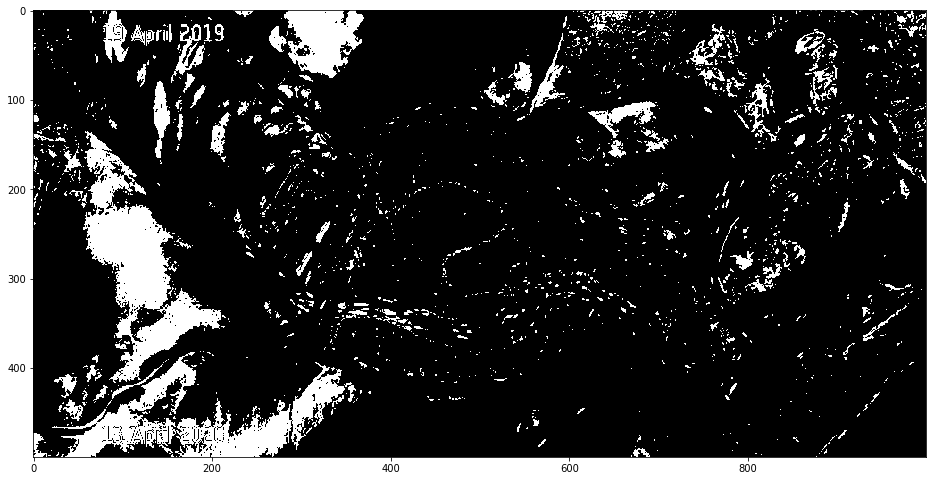

In [8]:
diff_copy = np.zeros(diff.shape)
diff_copy[(diff > 0.20625) | (diff < -0.20625)] = 1
plt.figure(figsize=(16, 9))
plt.imshow(diff_copy, cmap='gray')

Comme on peut le voir, avec une probabilité de fausse alarme fixée à 0.05, trop de pixels sont identifiés comme ayant changés. Le but ici étant de detecter les bateaux pour pouvoir les comptabiliser, on aimerait que le seuil soit plus élevé de manière à ne selectionner que les pixels de plus forte intensité dans l'image "diff". Ces pixels sont susceptibles de représenter des bateaux dans l'image de 2019 ou de 2020.

Or, on sait que la valeur du seuil ne dépend que de la probabilité de fausse alarme choisie. Celle-ci avait été fixé à 0.05 dans l'exemple precedent. On utilise a présent scipy stats pour calculer directement la valeur du seuil en fonction de la probabilité de fausse alarme (les calculs pour arriver à la formule ci-dessous est détaillée dans les feuilles de calcul).

In [9]:
import scipy.stats

n = scipy.stats.norm(0, 0.125)
seuil = n.ppf(1 - 1e-2)
print(seuil)

0.2907934842551051


Après tatonnement, une pfa fixé à 0.01 semble un bon choix car d'une part le seuil est plus élevé et donc on enleve beaucoup de bruit dans l'image, et d'autre part cela donne un seuil pas trop grand de manière à tout de même detecter de nombreux bateaux. Dans la suite pour obtenir l'image de sortie et le nombre de bateaux présents sur l'image différence (donc la somme du nombre de bateaux sur les images 2019 et 2020), on applique le même post-traitement que sur la partie TIFO.

Le nombre de bateaux sur les deux images est estime a: 264


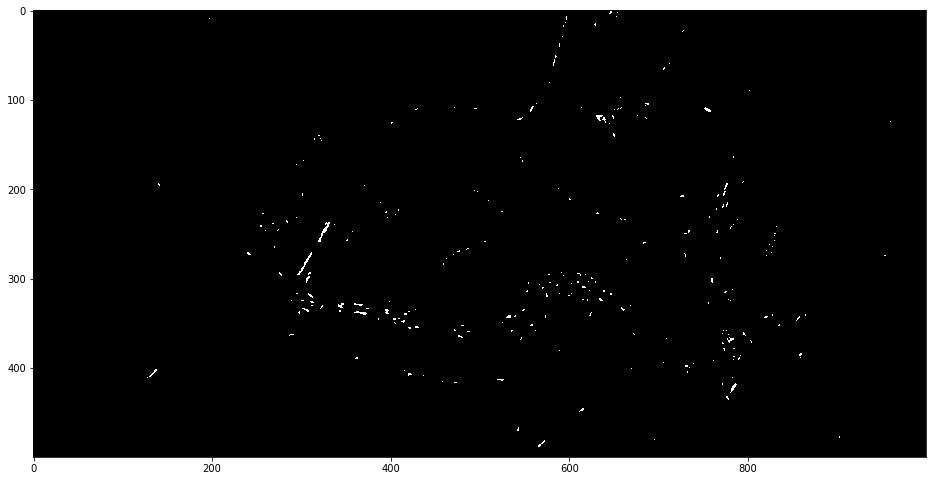

In [10]:
from skimage.morphology import binary_erosion, binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from skimage.segmentation import clear_border, flood, flood_fill
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.filters import threshold_yen, threshold_otsu

diff_copy = np.zeros(diff.shape)
diff_copy[(diff > seuil) | (diff < -seuil)] = 1
water_2020 = get_segmented_water('Venice_2020.png')
struct = disk(2)
water_2020 = binary_closing(water_2020, struct).astype(np.bool)
water_2020 = binary_erosion(water_2020, struct).astype(np.bool)
_, date_mask_2019 = get_date('Venice_2019.png')
_, date_mask_2020 = get_date('Venice_2020.png')

grayscale1 = rgb2gray(im)
grayscale2 = rgb2gray(im2)
thresh = threshold_yen(grayscale1)
yen1 = grayscale1 > thresh
thresh = threshold_yen(grayscale2)
yen2 = grayscale2 > thresh

diff_copy[(water_2020 == 0) | (date_mask_2019 == 1) | (date_mask_2020 == 1) | ((yen1 == 0) & (yen2 == 0))] = 0
diff_copy = binary_fill_holes(diff_copy).astype(np.bool)
diff_copy = clear_border(diff_copy)
l = label(diff_copy)
for region in regionprops(l):
    if region.area > 80 or region.extent < 0.15:
        diff_copy = flood_fill(diff_copy, tuple(region.coords[0, :]), 0)

label_image, num = label(diff_copy, return_num=True)
print(f"Le nombre de bateaux sur les deux images est estime a: {num}")
plt.figure(figsize=(16, 9))
plt.imshow(diff_copy, cmap='gray')

Dans la cellule suivante on essaye de répartir les bateaux dans l'image de 2019 et 2020. Pour cela on segmente les images 2019 et 2020 avec threshold_yen puis, pour chaque région labelisée dans l'image difference binarisée precedente, on regarde si le centroid de chaque forme est un pixel blanc dans chacune des deux images binarisées avec le threshold de yen. Les images affichées dans la cellule suivante sont les images de base binarisées avec le threshold de Yen (donc pas les images avec uniquement nos bateaux).

Le nombre de bateaux present dans l'image de 2019 est 218
Le nombre de bateaux present dans l'image de 2020 est 46


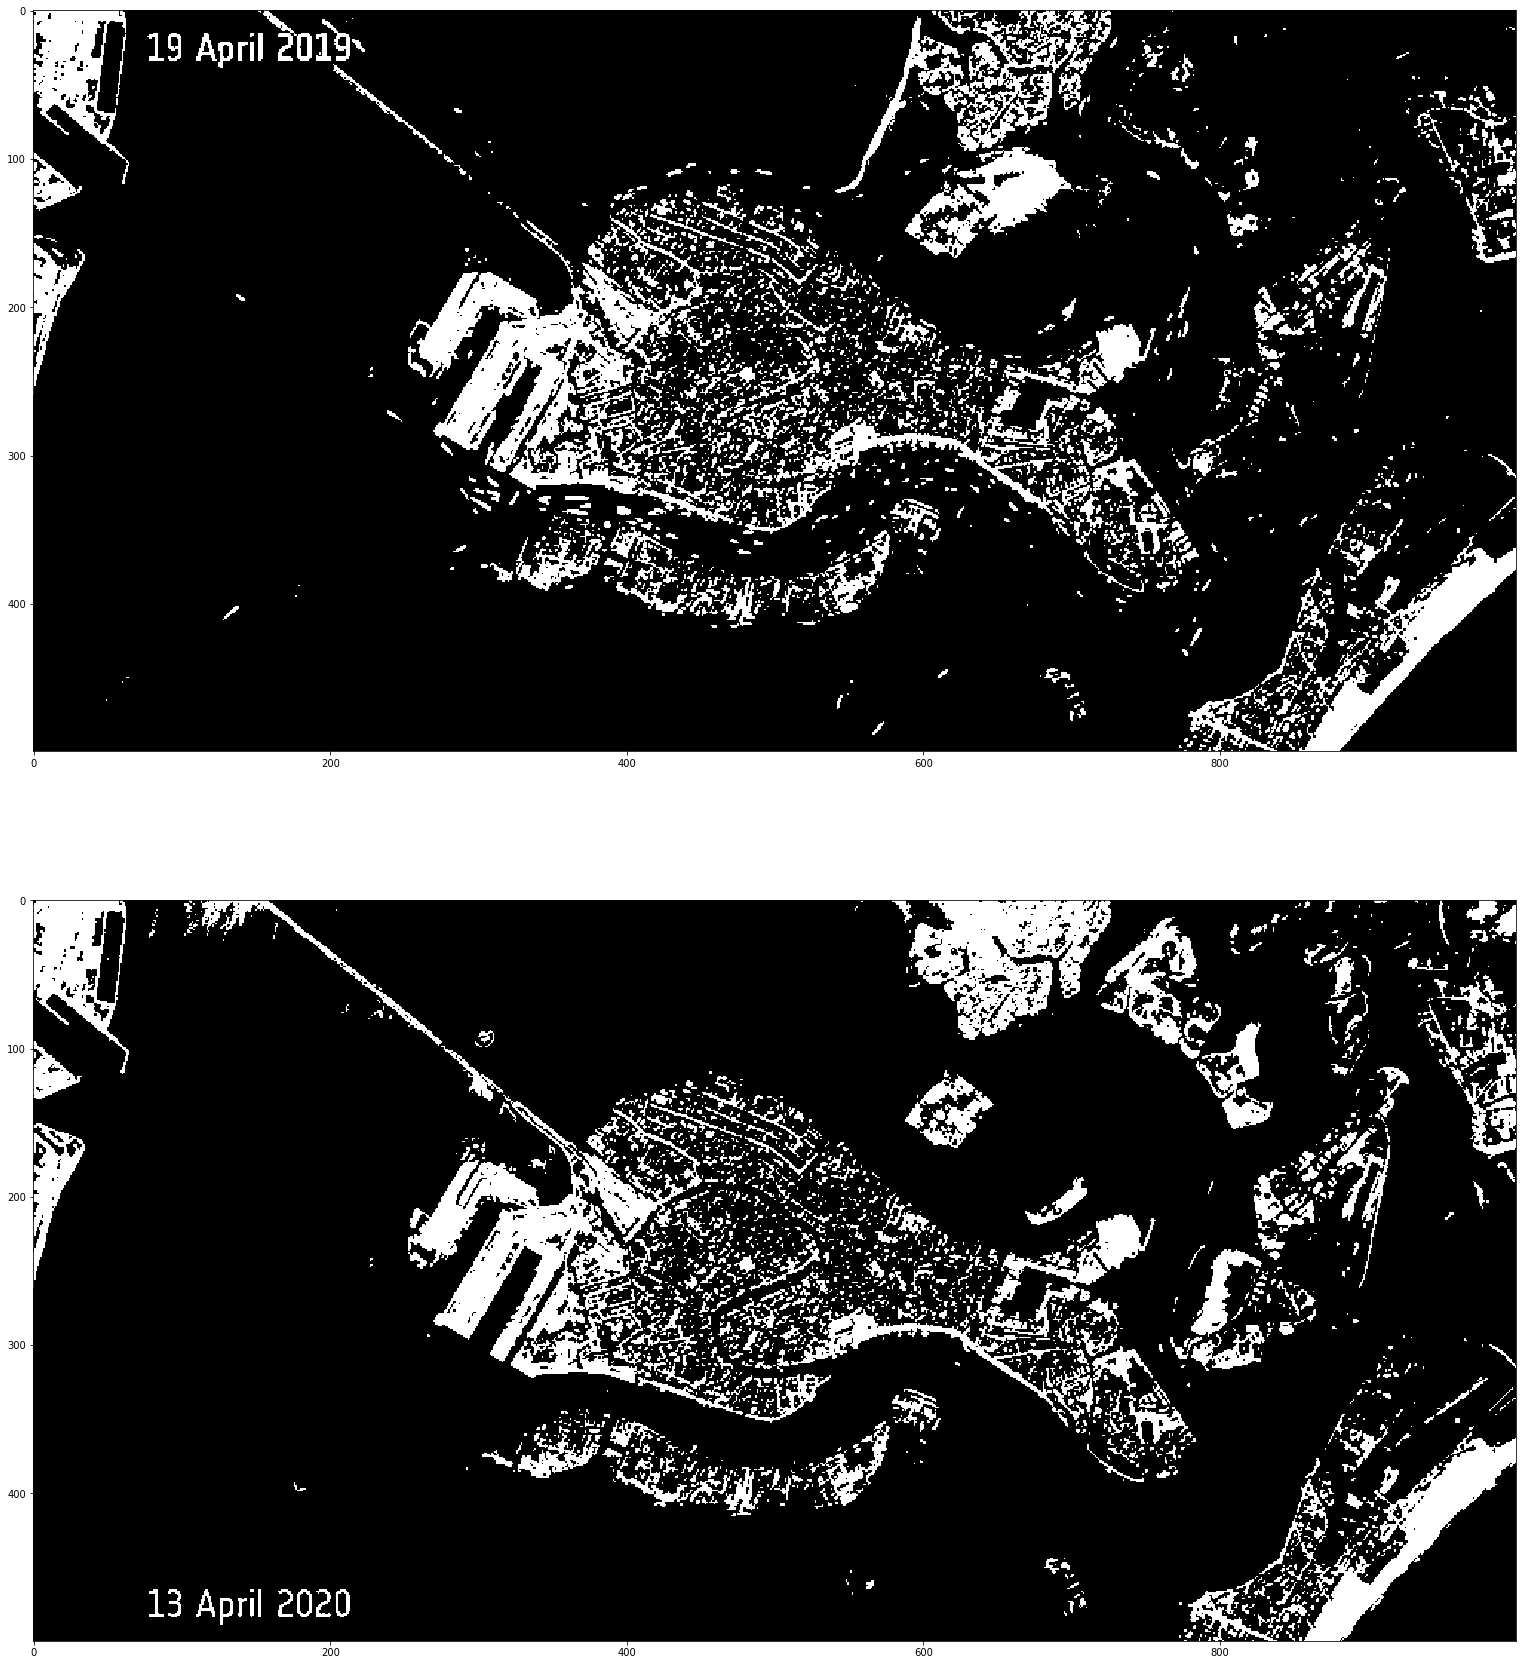

In [11]:
from skimage.color import rgb2gray
from skimage.filters import threshold_yen, threshold_otsu
from skimage.measure import label, regionprops

grayscale1 = rgb2gray(im)
grayscale2 = rgb2gray(im2)
thresh = threshold_yen(grayscale1)
yen1 = grayscale1 > thresh
thresh = threshold_yen(grayscale2)
yen2 = grayscale2 > thresh

ships_im1 = 0
ships_im2 = 0
for region in regionprops(label_image):
    centroid = np.asarray(region.centroid).astype(int)
    if yen1[centroid[0], centroid[1]] != 0:
        ships_im1 += 1
    if yen2[centroid[0], centroid[1]] != 0:
        ships_im2 += 1

print(f'Le nombre de bateaux present dans l\'image de 2019 est {ships_im1}')
print(f'Le nombre de bateaux present dans l\'image de 2020 est {ships_im2}')
fig, ax = plt.subplots(2, 1, figsize=(30, 30))
ax[0].imshow(yen1, cmap='gray')
ax[1].imshow(yen2, cmap='gray')